In [1]:
from ay_torch import *
import os

In [2]:
from cnn_sqptn1r_1 import SqPtn1rDataset
root='data_generated/sqptn1r/'

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= SqPtn1rDataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1rDataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][2])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][2])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_train[0] label value: tensor([0.3626])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_test[0] label value: tensor([0.7494])
dset_test[0][0] value range: tensor(0.) tensor(1.)


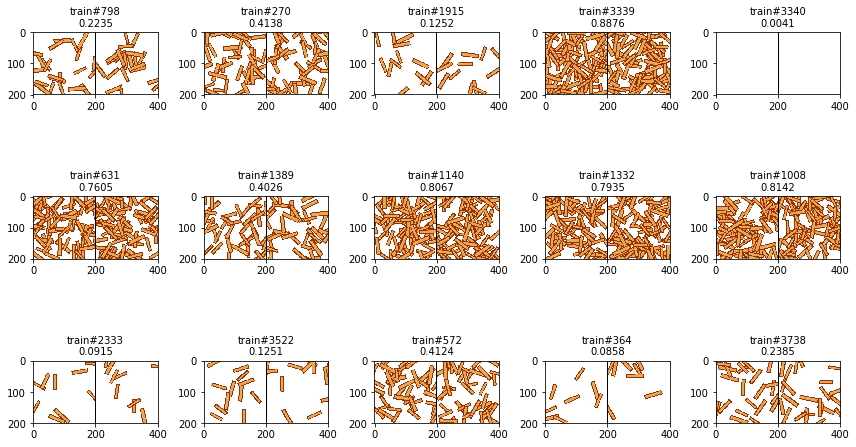

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [HStackImages(d[i][0],d[i][1]) for i in idxes]
labels= [f'train#{i}\n{d[i][2].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock

In [9]:
class TResDenseNet(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, resnet_args=None,
               n_hiddens=2, hidden_channels=256, p_dropout=0.0):
    super(TResDenseNet,self).__init__()
    default_resnet_args= dict(expansion=1, layers=[2, 2, 2, 2])
    resnet_args= MergeDict(default_resnet_args,resnet_args) if resnet_args else default_resnet_args
    self.resnet= TResNet(TResBlock, **resnet_args, in_channels=in_imgshape[0], with_fc=False)
    ndim_resnet= torch.flatten(self.resnet(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_resnet*2, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens-1)],
            torch.nn.Dropout(p_dropout) if n_hiddens-1>0 else None,
            torch.nn.Linear(hidden_channels, out_channels),
            )
    else:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(ndim_resnet*2, out_channels),
            )
  def forward(self, x1, x2):
    x= torch.cat((self.resnet(x1),self.resnet(x2)),1)
    return self.fc(x)

In [10]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNet(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),y
logger= TLogger()
disp= TDisp()

In [11]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNet                                       --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


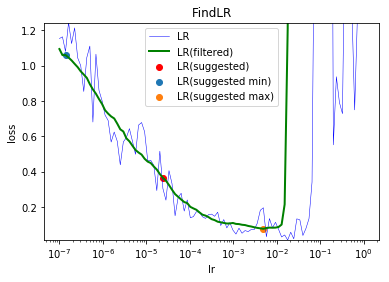

lr= 2.3988329190194914e-05, lr_min=1.3803842646028847e-07, lr_max=0.0048977881936844644


In [12]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
75	0.00023211	0.00068532	0.02587807	12.692064
76	0.00051441	0.00057594	0.02382704	12.800595
77	0.00053352	0.00062125	0.02479549	12.764260
78	0.00030702	0.00052498	0.02270901	12.654475
79	0.00019105	0.00046681	0.02136519	12.748285
i_epoch	loss(train)	loss(test)	metric(test)	time
80	0.00023634	0.00044676	0.02093299	12.763747
81	0.00060516	0.00068909	0.02610315	12.875621
82	0.00040236	0.00060422	0.02435285	12.791015
83	0.00022417	0.00050155	0.02216420	12.805248
84	0.00018965	0.00049553	0.02201398	12.802444
i_epoch	loss(train)	loss(test)	metric(test)	time
85	0.00023913	0.00065223	0.02537078	12.766841
86	0.00043110	0.00045715	0.02114777	12.773011
87	0.00042896	0.00053251	0.02280404	12.774483
88	0.00032937	0.00052963	0.02281857	12.783426
89	0.00018845	0.00045240	0.02101438	12.696433
i_epoch	loss(train)	loss(test)	metric(test)	time
90	0.00027141	0.00145968	0.03804333	12.750224
91	0.00062574	0.00056320	0.02344181	12.666065
92	0.00036522	0.000463

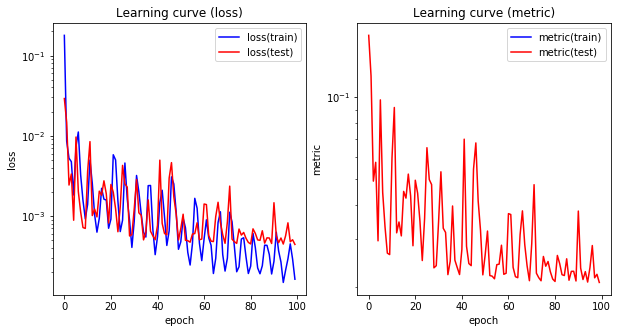

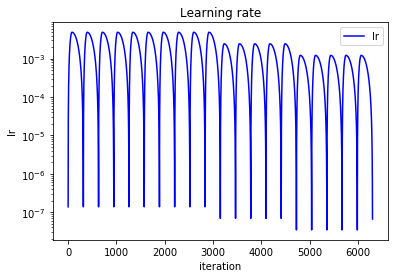

In [17]:
lr_min/=2;lr_max/=2
for i in range(5):
  FitOneCycle(net, n_epoch=5, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Plot()
logger.PlotLR()

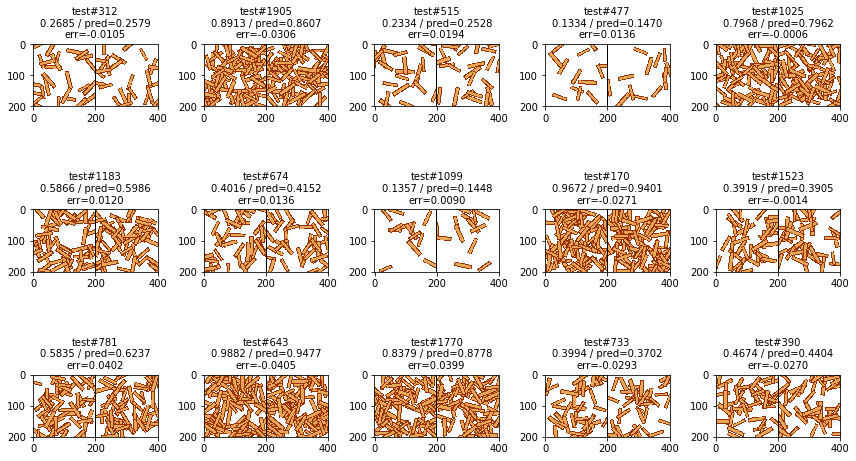

In [18]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= Eval(net,(imgs,imgsr),device=device).cpu()
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

# ResNet + ResDenseBlock + ResNetDecoder (Auto Encoder)

In [6]:
class TResDenseNetWithAE(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, layers=[2, 2, 2, 2], 
               encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=None, n_hiddens2=1, hidden_channels2=None, p_dropout=0.0):
    super(TResDenseNetWithAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_encoder, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
            torch.nn.Dropout(p_dropout) if n_hiddens>0 else None,
            # torch.nn.Linear(hidden_channels, latent_dim),
            TResDenseBlock(hidden_channels, latent_dim),
            )
    else:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            # torch.nn.Linear(ndim_encoder, latent_dim),
            TResDenseBlock(ndim_encoder, latent_dim),
            )
    if hidden_channels2 is not None:
      self.fc_out= torch.nn.Sequential(
            TResDenseBlock(latent_dim*2, hidden_channels2),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels2, hidden_channels2) for i in range(n_hiddens2)],
            torch.nn.Dropout(p_dropout) if n_hiddens2>0 else None,
            torch.nn.Linear(hidden_channels2, out_channels),
            )
    else:
      self.fc_out= torch.nn.Linear(latent_dim*2, out_channels)
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)
  def forward(self, x1, x2):
    x1_encoded,x2_encoded= self.encoder(x1),self.encoder(x2)
    h1,h2= self.fc_latent(x1_encoded),self.fc_latent(x2_encoded)
    y= self.fc_out(torch.cat((h1,h2),1))
    x1_reconstructed,x2_reconstructed= self.decoder(h1),self.decoder(h2)
    return y, x1_reconstructed, x2_reconstructed, h1, h2

class TRDNAELoss(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(TRDNAELoss,self).__init__()
    self.w_xtrg= w_xtrg
  def state_dict(self):
    return {'w_xtrg':self.w_xtrg}
  def load_state_dict(self, d):
    self.w_xtrg= d['w_xtrg']
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    if self.w_xtrg==0:
      return torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
    elif self.w_xtrg==1:
      return torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
    else:
      x_loss= torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
      y_loss= torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
      return self.w_xtrg*x_loss + (1.0-self.w_xtrg)*y_loss

class TRDNAEMetric(torch.nn.Module):
  def __init__(self):
    super(TRDNAEMetric,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    return torch.sqrt(torch.nn.functional.mse_loss(y, y_trg))

In [25]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2])
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2], hidden_channels=512, hidden_channels2=512, n_hiddens=2, n_hiddens2=2)
# , latent_dim=512
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=15, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELoss(w_xtrg=0.99)
f_metric= TRDNAEMetric()

def decode(pred):
  y,x1_reconstructed,x2_reconstructed,h1,h2= pred
  return y

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),(y,x1,x2)
logger= TLogger()
disp= TDisp()

In [26]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNetWithAE                                 --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


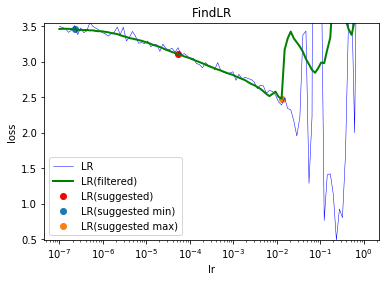

lr= 5.3703179637025284e-05, lr_min=2.2387211385683399e-07, lr_max=0.012882495516931335


In [31]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	0.13512630	0.13582646	0.02614537	15.792196
21	0.13612839	0.13597706	0.02669865	15.826738
22	0.13705449	0.13652657	0.03774957	15.878569
23	0.13872058	0.13729155	0.06348711	15.925770
24	0.13760645	0.13825157	0.05442590	15.931897
25	0.13710630	0.13488020	0.03737604	15.974702
26	0.13303221	0.13231217	0.02969930	15.929815
27	0.13243345	0.13145203	0.04043081	15.873035
28	0.13206439	0.12950942	0.03268606	15.893977
29	0.13029475	0.12864275	0.03049153	16.017839
30	0.12789968	0.12703995	0.02595912	16.009580
31	0.12668735	0.12620619	0.02251767	15.964727
32	0.12450271	0.12600028	0.03154360	15.996445
33	0.12341429	0.12523693	0.03312936	15.977962
34	0.12259494	0.12489208	0.02844275	15.952679
35	0.12144310	0.12394339	0.02217190	15.934305
36	0.11993932	0.12387384	0.02214575	15.931425
37	0.11912098	0.12357739	0.02212410	15.951845
38	0.11871882	0.12386674	0.02211197	15.926103
39	0.11835470	0.12343741	0.02119451	15.983790
i_epoch	loss(train)	loss(test)	

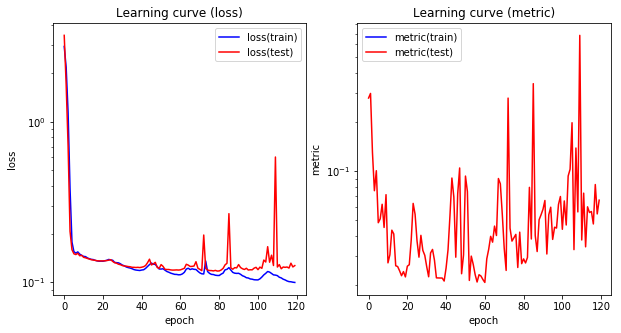

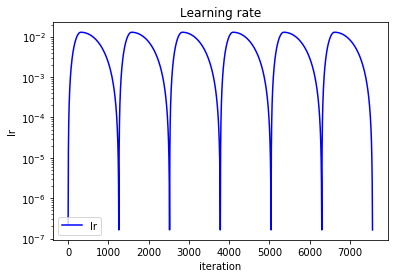

In [34]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
# lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(5):
  FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


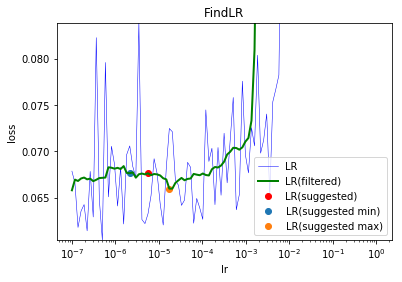

lr= 5.62341325190349e-06, lr_min=2.137962089502232e-06, lr_max=1.7378008287493757e-05


In [35]:
f_loss.w_xtrg= 0.5
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))
UnfreezeAllParameters(net)

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
175	0.06215426	0.07539916	0.01962780	14.600020
176	0.06223509	0.07492452	0.01910482	14.692992
177	0.06271586	0.07588219	0.02003645	14.660671
178	0.06196650	0.07547696	0.01967068	14.626945
179	0.06189029	0.07787362	0.02158006	14.652126
i_epoch	loss(train)	loss(test)	metric(test)	time
180	0.06233012	0.07949765	0.02279967	14.711300
181	0.06293798	0.07639168	0.01992791	14.646651
182	0.06281531	0.07534183	0.01952691	14.755443
183	0.06137394	0.07563832	0.01984081	14.709468
184	0.06147335	0.08164542	0.02428745	14.816868
i_epoch	loss(train)	loss(test)	metric(test)	time
185	0.06200959	0.08094370	0.02364198	14.696529
186	0.06311570	0.07754411	0.02123708	14.652051
187	0.06387495	0.07684453	0.02082721	14.729930
188	0.06169347	0.07464736	0.01907326	14.731474
189	0.06158515	0.08089381	0.02379227	14.764443
i_epoch	loss(train)	loss(test)	metric(test)	time
190	0.06122247	0.07784064	0.02136256	14.646790
191	0.06240734	0.07633598	0.02028272	14.675726
192	0

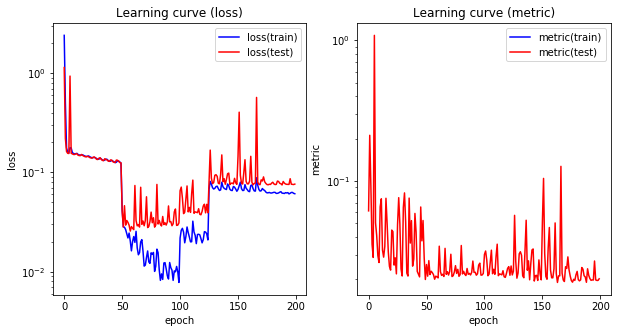

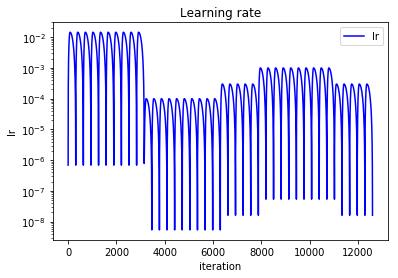

In [39]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,5e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=5, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Plot()
logger.PlotLR()

## Results with latent_dim=256
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

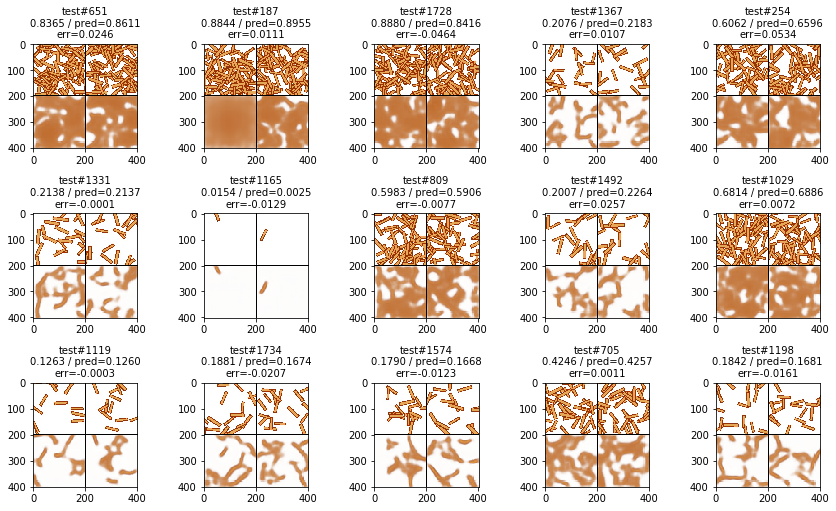

In [38]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Results with latent_dim=15
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=15, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

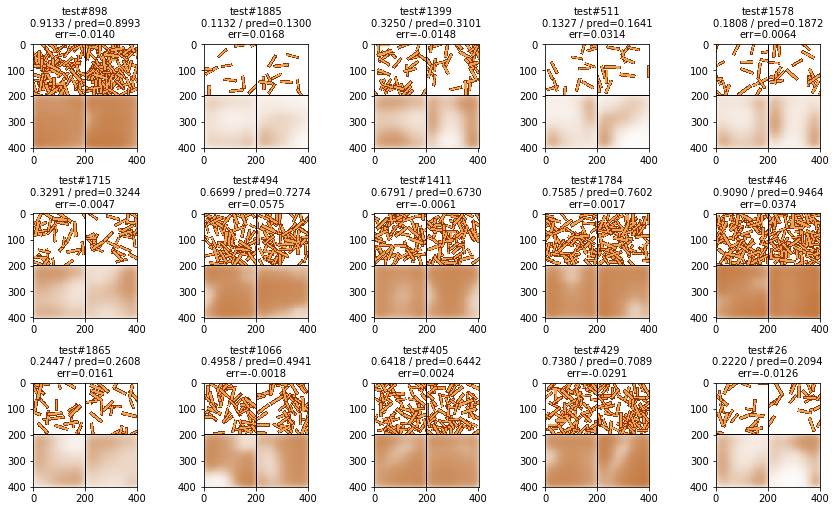

In [15]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)